In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.integrate import trapezoid
from Utilities.basic_units import radians
from Utilities.time_extractor import days_since_distruption

from Utilities.operators import make_tree
import Utilities.prelude

In [2]:
folder = 'TDE'
is_tde = True
snap = '196'
m = 5
beta = 2 
path = f'{folder}/{snap}'
G = 1
G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rt =  (M_bh)**(1/3)
Rp = Rt / beta
R0 = 0.6 * Rp

In [22]:
def to_cylindric(x,y):
    if x.any() == 0:
        if y.any()>0:
            theta_coord = np.pi/2
        elif y.any() == 0:
            theta_coord = 0
        else:
            theta_coord = 3/2 * np.pi
    else:
        theta_coord = np.arctan2(y,x)
    radius = np.sqrt(x**2+y**2)
    return radius, theta_coord

def from_cylindric(theta, r):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def orbital_energy(r, v, M = M_bh):
    energy = G*M/r - v**2/2
    return energy

def keplerian_orbit(theta, a = Rp, ecc = 1):
    p = 2 * a
    radius = p / (1 + ecc * np.cos(theta))
    return radius

def dtheta_keplerian_orbit(theta, a = Rp, ecc = 1):
    p = 2 * a
    dr_dtheta = ecc * p * np.sin(theta)/ (1 + ecc * np.cos(theta))**2
    return dr_dtheta

def tangent_plane(x_data, y_data, dim_data, x_orbit, y_orbit, theta_chosen, radius_chosen):
    # Find the slope of the line
    x_chosen, y_chosen = from_cylindric(theta_chosen, radius_chosen)
    # Search where you are in the orbit to then find the previous point
    idx_chosen = np.argmin(np.abs(y_chosen - y_orbit)) # orizontal parabola --> unique y values
    if theta_chosen == 0:
        condition_coord = np.abs(x_data-radius_chosen) < dim_data #i.e. x=Rchosen, which should be pericenter (vertical line)
    else:
        m = (y_orbit[idx_chosen] - y_orbit[idx_chosen-1]) / (x_orbit[idx_chosen] - x_orbit[idx_chosen-1])
        ideal_y_value = y_chosen + m * (x_data-x_chosen)
        condition_coord = np.abs(y_data - ideal_y_value) < dim_data
    return condition_coord

def normal_plane(x_data, y_data, dim_data, theta_chosen):
    if np.abs(theta_chosen) == np.pi/2:
        condition_coord = np.abs(y_data) < dim_data # horizontal line
    else:
        m = np.tan(theta_chosen)
        condition_coord = np.abs(y_data - m * x_data) < dim_data
        if theta_chosen < 0:
            condition_coord = np.logical_and(condition_coord, y_data > 0)
        else:
            condition_coord = np.logical_and(condition_coord, y_data < 0)
    return condition_coord

def find_maxima_density(x_data, y_data, dim_data, den_data, theta_arr):
    x_maxima = np.zeros(len(theta_arr))
    y_maxima = np.zeros(len(theta_arr))
    for i,theta in enumerate(theta_arr):
        condition_coord = normal_plane(x_data, y_data, dim_data, theta)
        idx_max = np.argmax(den_data[condition_coord])   
        x_maxima[i] = x_data[condition_coord][idx_max]
        y_maxima[i] = y_data[condition_coord][idx_max]
    return x_maxima, y_maxima

def find_arclenght(theta_data, r_data):
    s_data = np.zeros(len(theta_data))
    
    drdtheta_data = dtheta_keplerian_orbit(theta_data)
    ds = np.sqrt(r_data**2 + drdtheta_data**2)

    # Broadcast to integrate modify data to integrate: theta is from pi to -np.pi, but you should start integrate from 0
    theta_first = np.pi - theta_data[theta_data>=0]
    theta_second = np.pi + np.abs(theta_data[theta_data<0])
    theta_broadcasted = np.concatenate((theta_first, theta_second))
    
    for i in range(len(theta_broadcasted)):
        s_data[i] = trapezoid(ds[:i+1], theta_broadcasted[:i+1])

    return s_data

def find_sz_plane(theta_data, r_data, z_data, f_data, theta_orbit, r_orbit, a = Rp, arc_length = True):
    """
    Parameters
    --------
    theta_data, r_data, z_data, f_data: array.
        Simulation cells' values of THETA_cyl, R_cyl, Z, quantity f.
    theta_orbit, r_orbit: array.
        Orbit's angles/radii.
    Returns
    --------
    f_sz, z_sz, theta_broadcast: array.
        (Broadcasted) profile of f ((and the corresponding height)  for each point on the orbit
    """
    f_sz = []
    z_sz = []
    for i,theta in enumerate(theta_orbit):
        condition_theta = np.abs(theta-theta_data)<0.08
        condition_r = np.abs(r_orbit[i]-r_data)<0.08
        condition = np.logical_and(condition_theta, condition_r)
        f_sz.append(f_data[condition])
        z_sz.append(z_data[condition])

    # Broadcast so that then you can easily plot
    length = np.zeros(len(z_sz))
    for i in range(len(z_sz)):
        length[i] = int(len(z_sz[i]))
    theta_broadcast = np.repeat(theta_orbit, list(length))
    f_sz = np.concatenate(f_sz)
    z_sz = np.concatenate(z_sz)

    if arc_length:
        dorbit_dtheta = dtheta_keplerian_orbit(theta_orbit, a)
        s_data = find_arclenght(theta_orbit, r_orbit)
        s_broadcast = np.repeat(s_data, list(length))
        return f_sz, z_sz, theta_broadcast, s_broadcast
    
    else:
        return f_sz, z_sz, theta_broadcast


Load data

In [4]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp, IE, Diss, Entropy = make_tree(path, snap, is_tde, energy = True)
RADIUS_cyl, THETA = to_cylindric(X, Y)
R = np.sqrt(X**2 + Y**2 + Z**2)
Vcyl = np.sqrt(VX**2 + VY**2)
dim_cell = Vol**(1/3) # according to Elad
time, days = days_since_distruption(f'TDE/{snap}/snap_{snap}.h5', m, 'tfb')

days after disruption: 2.7332186695503924, t_fall: 12.649110640673518


(-100.0, 100.0)

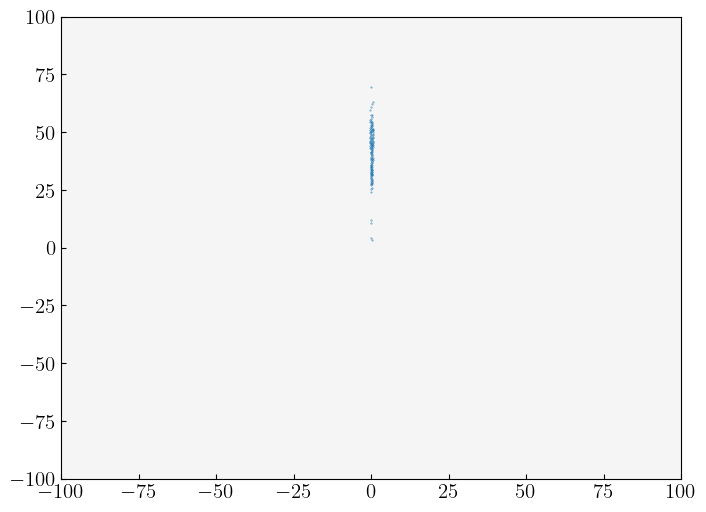

In [33]:
conditionn = np.logical_and(np.abs(Z) < 0.1, np.abs(THETA-np.pi/2) < 0.01)
plt.scatter(X[conditionn], Y[conditionn],  s = 0.1)
plt.xlim(-100,100)
plt.ylim(-100,100)

In [6]:
div = np.load(f'{folder}/{snap}/DivV_{snap}.npy')
shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

# Shock zone
idx_zone = shockzone[0]
idx_zone = np.array([int(i) for i in idx_zone])
x_zone = X[idx_zone]
y_zone = Y[idx_zone]
z_zone = Z[idx_zone]
Vx_zone = VX[idx_zone]
Vy_zone = VY[idx_zone]
Vz_zone = VZ[idx_zone]
Diss_zone = Diss[idx_zone]
dim_cell_zone = dim_cell[idx_zone]
div_zone = div[idx_zone]

# Shock surface
idx_surf = shocksurface[0]
idx_surf = np.array([int(i) for i in idx_surf])
x_surf = x_zone[idx_surf]
y_surf = y_zone[idx_surf]
z_surf = z_zone[idx_surf]
Vx_surf = Vx_zone[idx_surf]
Vy_surf = Vy_zone[idx_surf]
dim_cell_surf = dim_cell_zone[idx_surf]
div_surf = div_zone[idx_surf]


Y-Z plane. We want to reproduce Shiokawa+15 (note that you have to considr the tangent plane at pericenter, i.e. a cross section along X=Rp for us)

In [7]:
cross_sect = np.abs(X-Rp)< dim_cell
lim = np.logical_and(np.abs(Y)<100, np.abs(Z)<50)
shio = np.logical_and(cross_sect, lim)

cross_sect_surf = np.abs(x_surf-Rp)< dim_cell_surf
lim_surf = np.logical_and(np.abs(y_surf)<100, np.abs(z_surf)<50)
shio_surf = np.logical_and(cross_sect_surf, lim_surf)

Y_shio = Y[shio]
Z_shio = Z[shio]
VY_shio = VY[shio]
VZ_shio = VZ[shio]
Den_shio = Den[shio]
Entropy_shio = Entropy[shio]
shio_tree = KDTree(np.transpose([Y_shio, Z_shio]))

y_surf_shio = y_surf[shio_surf]
z_surf_shio = z_surf[shio_surf]

# extend data for the plot
Y_shio_interp = np.arange(np.min(Y_shio), np.max(Y_shio))
Z_shio_interp = np.arange(np.min(Z_shio), np.max(Z_shio), 0.1)
Entropy_shio_interp = np.zeros((len(Y_shio_interp), len(Z_shio_interp)))

for i in range(len(Y_shio_interp)):
    for j in range(len(Z_shio_interp)):
        point = np.array([Y_shio_interp[i], Z_shio_interp[j]])
        _, idx = shio_tree.query(point)
        Entropy_shio_interp[i, j] = Entropy_shio[idx]


Text(0.5, 0.98, 'Cross section, X = $R_p$')

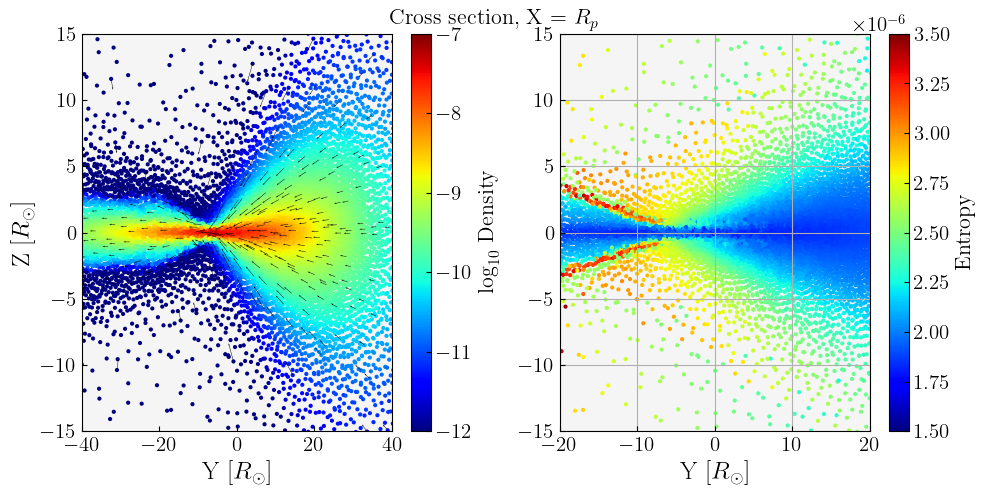

In [8]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
img = ax[0].scatter(Y_shio, Z_shio, c = np.log10(Den_shio), s = 4, cmap = 'jet', vmin = -12, vmax = -7)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[0].quiver(Y_shio[::40], Z_shio[::40], VY_shio[::40], VZ_shio[::40], color = 'k', angles='xy', scale_units='xy', width = 1.5e-3, scale = 40)
ax[0].set_xlim(-40,40)
# ax[0].gca().invert_xaxis()
ax[0].set_ylim(-15,15)
ax[0].set_xlabel(r'Y [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Z [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(Y_shio, Z_shio, c = Entropy_shio, s = 4, cmap = 'jet', vmin = 1.5e-6, vmax = 3.5e-6)
cbar = plt.colorbar(img1)#, format='%.0e')
cbar.set_label(r'Entropy', fontsize = 16)
ax[1].set_xlim(-20,20)
ax[1].set_ylim(-15,15)
ax[1].set_xlabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()

plt.tight_layout()
plt.suptitle(r'Cross section, X = $R_p$', fontsize = 16)


Text(0.5, 1.0, 'Cross section at X = $R_p$')

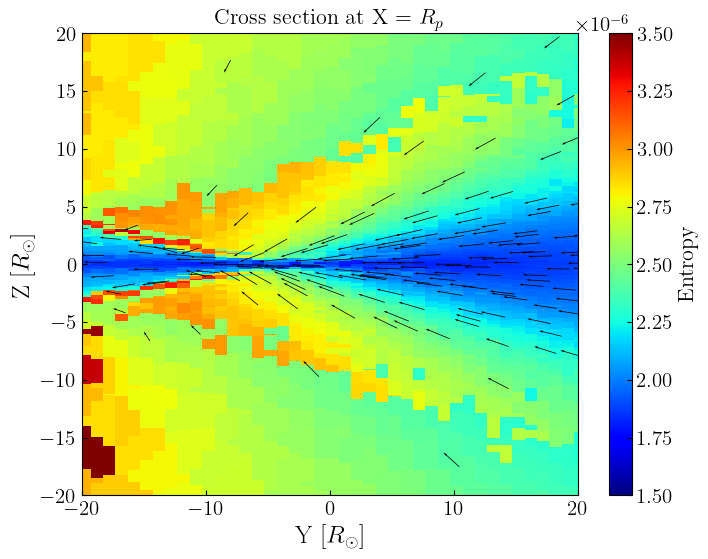

In [9]:
plt.figure(figsize = (8,6))
img = plt.pcolormesh(Y_shio_interp, Z_shio_interp, Entropy_shio_interp.T, cmap = 'jet', vmin = 1.5e-6, vmax = 3.5e-6)
plt.quiver(Y_shio[::40], Z_shio[::40], VY_shio[::40], VZ_shio[::40], color = 'k', angles='xy', scale_units='xy', width = 1.5e-3, scale = 40)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'Entropy', fontsize = 16)
# plt.scatter(y_surf_shio, z_surf_shio, s = 4, color='k')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.xlabel(r'Y [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Z [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section at X = $R_p$', fontsize = 16)

Midplane and keplerian orbit

In [8]:
midplane = np.abs(Z) < dim_cell
X_midplane = X[midplane]
Y_midplane = Y[midplane]
VX_midplane = VX[midplane]
VY_midplane = VY[midplane]
Vol_midplane = Vol[midplane]
Temp_midplane = Temp[midplane]
Den_midplane = Den[midplane]
Entropy_midplane = Entropy[midplane]
energy_midplane = orbital_energy(RADIUS_cyl[midplane], Vcyl[midplane])
log_energy_midplane = np.log10(energy_midplane)
log_energy_midplane = np.nan_to_num(log_energy_midplane, neginf = -1000)

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_40156/2475286921.py:11: RuntimeWarning: invalid value encountered in log10
  log_energy_midplane = np.log10(energy_midplane)


In [29]:
# keplerian orbit and tidal radius
theta_lim = 3/4 * np.pi
# orbit goes from np.pi to -np.pi 
theta_arr = np.concatenate((np.arange(-theta_lim, 0, 0.01), np.arange(0, theta_lim, 0.01))) #0.01 as the epsilon in the find_sz plane function
orbit = keplerian_orbit(theta_arr, a = Rp)
x_orbit, y_orbit = from_cylindric(theta_arr, orbit) 
#dorbit_dtheta = dtheta_keplerian_orbit(theta_arr, a = Rp)

delta_r = 5
lower_orbit = orbit - delta_r
x_lower_orbit, y_lower_orbit = from_cylindric(theta_arr, lower_orbit) 
upper_orbit = orbit + delta_r
x_upper_orbit, y_upper_orbit = from_cylindric(theta_arr, upper_orbit) 

# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2

S-Z plane

In [30]:
theta_chosen = np.pi/8
radius_chosen = keplerian_orbit(theta_chosen, a = Rp)
x_chosen, y_chosen = from_cylindric(theta_chosen, radius_chosen)

condition_tg = tangent_plane(X, Y, dim_cell, x_orbit, y_orbit, theta_chosen, radius_chosen)
X_tg = X[condition_tg]
Y_tg = Y[condition_tg]
Z_tg = Z[condition_tg]
Den_tg = Den[condition_tg]
theta_tg = THETA[condition_tg]
X_tg_midplane = X_tg[np.abs(Z_tg) < dim_cell[condition_tg]]
Y_tg_midplane = Y_tg[np.abs(Z_tg) < dim_cell[condition_tg]]

condition_norm = normal_plane(X, Y, dim_cell, theta_chosen)
X_norm = X[condition_norm]
Y_norm = Y[condition_norm]
Z_norm = Z[condition_norm]
Den_norm = Den[condition_norm]
RADIUS_cyl_norm = RADIUS_cyl[condition_norm]
X_norm_midplane = X_norm[np.abs(Z_norm) < dim_cell[condition_norm]]
Y_norm_midplane = Y_norm[np.abs(Z_norm) < dim_cell[condition_norm]]

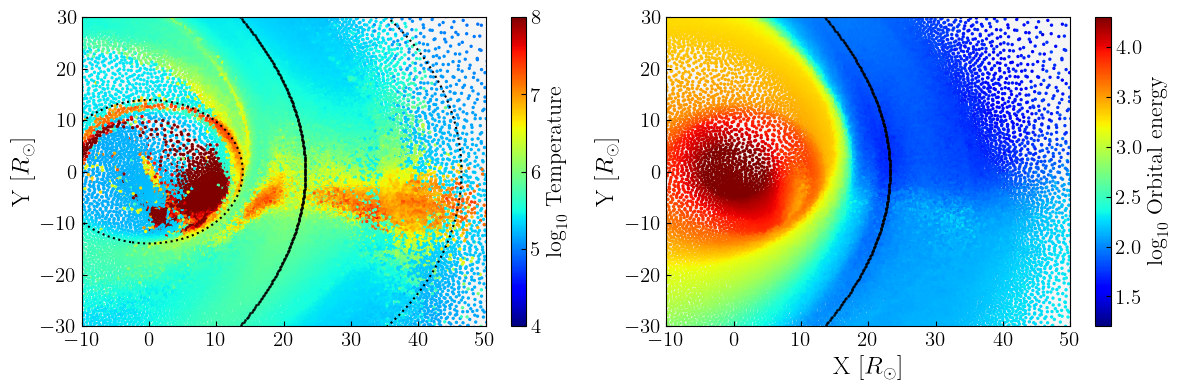

In [13]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
img = ax[0].scatter(X_midplane, Y_midplane, c = np.log10(Temp_midplane), s = 2, cmap = 'jet', vmin = 4, vmax = 8)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Temperature', fontsize = 16)
ax[0].contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax[0].contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
ax[0].scatter(x_orbit, y_orbit, color = 'k', s = 1, alpha = 0.8)
ax[0].set_xlim(-10,50)
ax[0].set_ylim(-30,30)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img = ax[1].scatter(X_midplane, Y_midplane, c = log_energy_midplane, s = 2, cmap = 'jet', vmin = 1.2, vmax = 4.3)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Orbital energy', fontsize = 16)
ax[1].scatter(x_orbit, y_orbit, color = 'k', s = 1, alpha = 0.8)
ax[1].set_xlim(-10,50)
ax[1].set_ylim(-30,30)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[1].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

plt.tight_layout()

In [15]:
x_maxima, y_maxima = find_maxima_density(X, Y, dim_cell, Den, theta_arr)

Text(0, 0.5, 'Y [$R_\\odot$]')

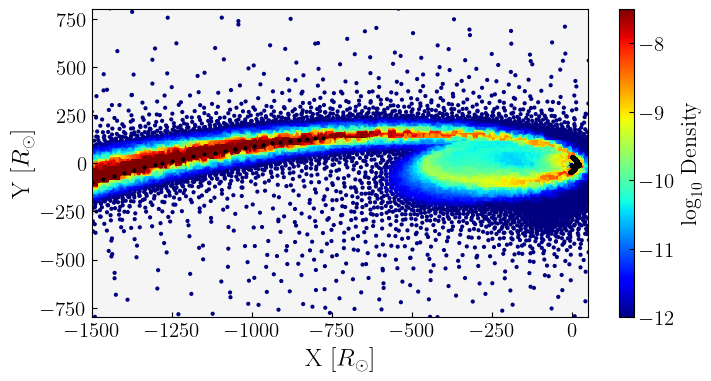

In [20]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
img = ax.scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 4, cmap = 'jet', vmin = -12, vmax = -7.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.scatter(x_maxima, y_maxima, s = 4, c = 'k')
ax.set_xlim(-1500,50)
ax.set_ylim(-800,800)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

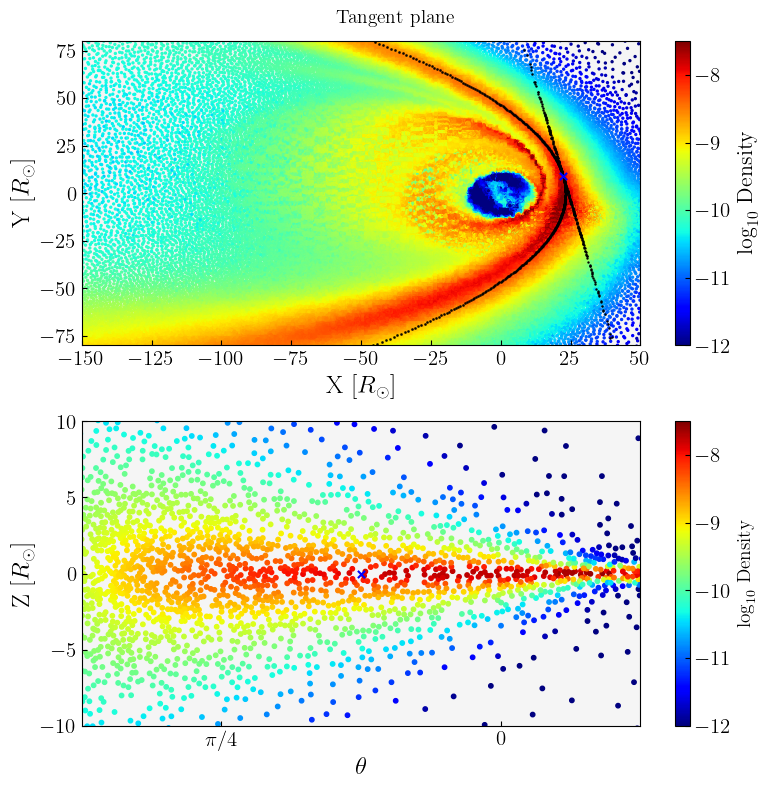

In [14]:
fig, ax = plt.subplots(2,1, figsize = (8,8))
img = ax[0].scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 2, cmap = 'jet', vmin = -12, vmax = -7.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[0].scatter(X_tg_midplane, Y_tg_midplane, s = 0.5, c = 'k')
ax[0].scatter(x_orbit, y_orbit, color = 'k', s = 1, alpha = 0.8)
ax[0].scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'b')
ax[0].set_xlim(-150,50)
ax[0].set_ylim(-80,80)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(theta_tg * radians, Z_tg, xunits=radians, c = np.log10(Den_tg),  cmap = 'jet', s = 10, vmin = -12, vmax = -7.5)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'$\log_{10}$ Density', fontsize = 14)
ax[1].scatter(theta_chosen, 0, marker = 'x', s = 27, c = 'b')
if theta_chosen < np.pi :
    ax[1].invert_xaxis()
    ax[1].set_xlim(theta_chosen + np.pi/4, theta_chosen - np.pi/4)
else: 
    ax[1].set_xlim(- np.pi/4, np.pi/4)
ax[1].set_ylim(-10,10)
ax[1].set_xlabel(r'$\theta$', fontsize = 18)
ax[1].set_ylabel(r'Z [$R_\odot$]', fontsize = 18)

plt.suptitle('Tangent plane', fontsize = 14)
plt.tight_layout()

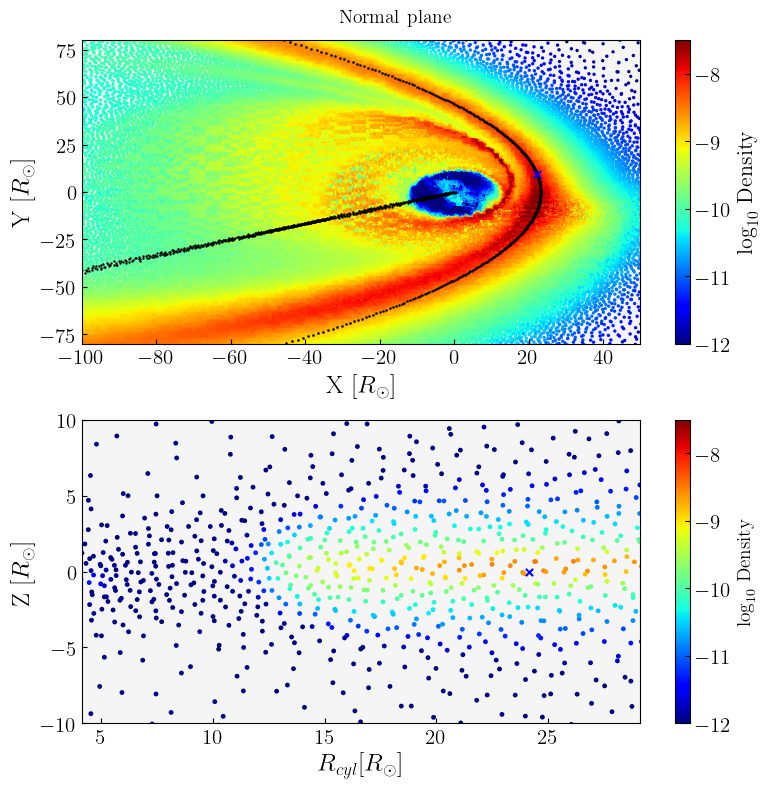

In [31]:
fig, ax = plt.subplots(2,1, figsize = (8,8))
img = ax[0].scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 2, cmap = 'jet', vmin = -12, vmax = -7.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[0].scatter(X_norm_midplane, Y_norm_midplane, s = 0.5, c = 'k')
ax[0].scatter(x_orbit, y_orbit, color = 'k', s = 1, alpha = 0.8)
ax[0].scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'b')
ax[0].set_xlim(-100,50)
ax[0].set_ylim(-80,80)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(RADIUS_cyl_norm, Z_norm, c = np.log10(Den_norm),  cmap = 'jet', s = 6, vmin = -12, vmax = -7.5)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'$\log_{10}$ Density', fontsize = 14)
ax[1].scatter(radius_chosen, 0, marker = 'x', s = 27, c = 'b')
ax[1].set_xlim(radius_chosen - 20, radius_chosen + 5)
ax[1].set_ylim(-10,10)
ax[1].set_xlabel(r'$R_{cyl} [R_\odot]$', fontsize = 18)
ax[1].set_ylabel(r'Z [$R_\odot$]', fontsize = 18)

plt.suptitle('Normal plane', fontsize = 14)
plt.tight_layout()

In [16]:
# zoom in to see the wiggle for theta = 0
if theta_chosen == 0:
    plt.figure(figsize = (8,4))
    img1 = plt.scatter(theta_tg* radians, Z_tg, xunits=radians, c = np.log10(Den_tg),  cmap = 'jet', s = 4, vmin = -12, vmax = -7)
    cbar1 = plt.colorbar(img1)#, format='%.0e')
    cbar1.set_label(r'$\log_{10}$ Density', fontsize = 14)
    if theta_chosen < np.pi :
        plt.gca().invert_xaxis()
        plt.xlim(np.pi/4, -np.pi/4)
    else: 
        plt.xlim(-np.pi/4, np.pi/4)
    plt.ylim(-5,5)
    plt.xlabel(r'$\theta$', fontsize = 14)
    plt.ylabel(r'Z [$R_\odot$]', fontsize = 14)


In [17]:
Den_sz, Z_sz, theta_broad, s_broadcast = find_sz_plane(THETA, RADIUS_cyl, Z, Den, theta_arr, orbit)

Text(0, 0.5, 'Z [$R_\\odot$]')

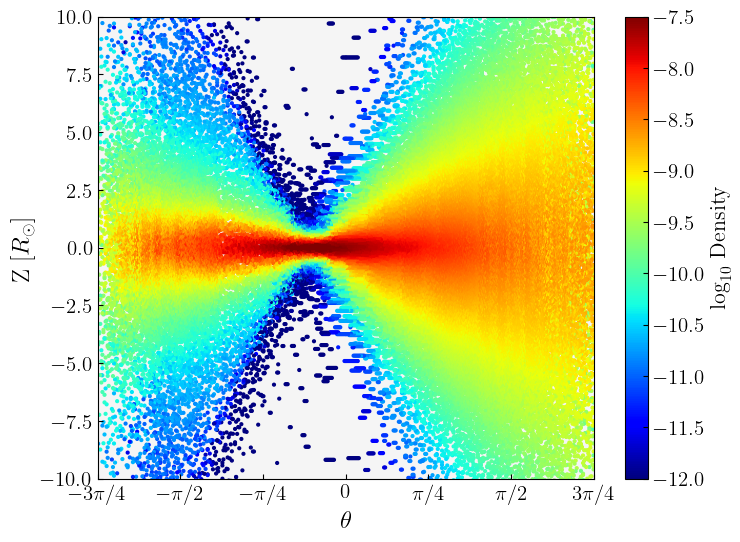

In [18]:
plt.figure()
img = plt.scatter(theta_broad * radians, Z_sz, c = np.log10(Den_sz), xunits = radians, s= 4, cmap = 'jet', vmin = -12, vmax = -7.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
plt.ylim(-10,10)
plt.xlim(-theta_lim, theta_lim)
plt.xlabel(r'$\theta$', fontsize = 18)
plt.ylabel(r'Z [$R_\odot$]', fontsize = 18)

In [19]:
s_data = find_arclenght(theta_arr, orbit)
s_lower_data = find_arclenght(theta_arr, lower_orbit)
s_upper_data = find_arclenght(theta_arr, upper_orbit)

idx_pericenter = np.argmin(np.abs(theta_arr))

Text(0, 0.5, 'Z [$R_\\odot$]')

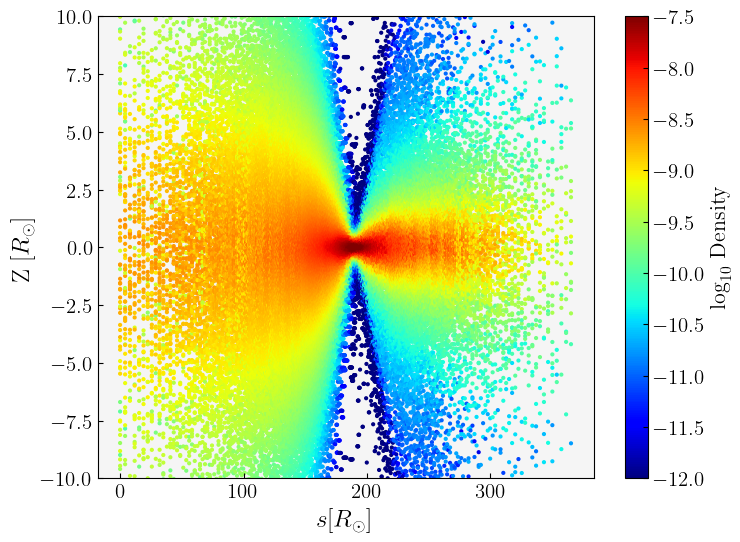

In [20]:
plt.figure()
img = plt.scatter(s_broadcast, Z_sz, c = np.log10(Den_sz), s= 4, cmap = 'jet', vmin = -12, vmax = -7.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
plt.ylim(-10,10)
plt.xlabel(r'$s [R_\odot]$', fontsize = 18)
plt.ylabel(r'Z [$R_\odot$]', fontsize = 18)

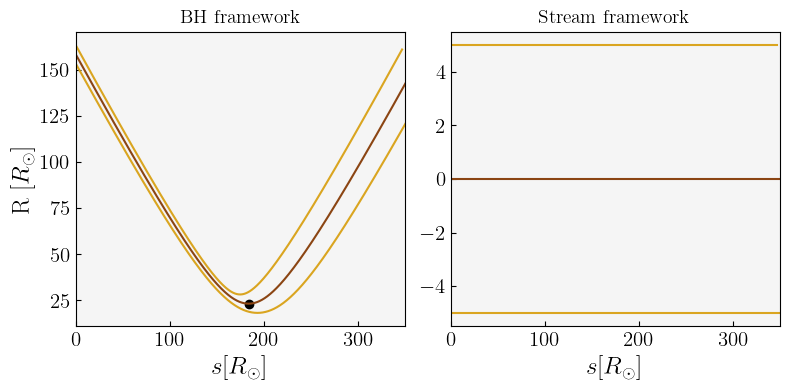

In [21]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
# ax[0][0].plot(x_orbit, y_orbit, color = 'saddlebrown', alpha = 0.8)
# ax[0][0].scatter(x_orbit[idx_pericenter],y_orbit[idx_pericenter], c = 'k')
# ax[0][0].plot(x_lower_orbit, y_lower_orbit, color = 'goldenrod', alpha = 0.8)
# ax[0][0].plot(x_upper_orbit, y_upper_orbit, color = 'goldenrod', alpha = 0.8)
# ax[0][0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
# ax[0][0].set_ylabel(r'$Y [R_\odot$]', fontsize = 18)

ax[0].plot(s_data, orbit, c = 'saddlebrown')
ax[0].scatter(s_data[idx_pericenter], orbit[idx_pericenter], c = 'k')
ax[0].plot(s_upper_data, lower_orbit, c = 'goldenrod')
ax[0].plot(s_lower_data, upper_orbit, c = 'goldenrod')
ax[0].set_xlabel(r'$s [R_\odot]$', fontsize = 18)
ax[0].set_ylabel(r'R [$R_\odot$]', fontsize = 18)
ax[0].set_xlim(0,350)
ax[0].set_title('BH framework', fontsize = 14)

ax[1].plot(s_data, orbit - orbit, c = 'saddlebrown')
ax[1].plot(s_upper_data, lower_orbit - orbit, c = 'goldenrod')
ax[1].plot(s_lower_data, upper_orbit - orbit, c = 'goldenrod')
ax[1].set_xlabel(r'$s [R_\odot]$', fontsize = 18)
ax[1].set_xlim(0,350)
ax[1].set_title('Stream framework', fontsize = 14)

plt.tight_layout()